As part of this project, I wanted to look to see if it's possible to use NLP to parse the words in order to predict the numberes of stars given by the review.  The dataset used is the Yelp Dataset: Round 11: https://www.yelp.com/dataset/challenge

Techniques

1) I wanted to look at restaurants reviews, and therefore it was necessary to parse the business.json to extract those that are reviews.  I had started the IDs in a set given fast O(1) lookup.  


2) After determining the number of rows in the review.json file, I had extracted the review text and star rating from the file by parsing the json file line-by-line.  Parsing of 3 million rows took less than a minute thanks to fast lookup of the set and preallocated numpy arrays. Afterwards null entries were removed.  


3) 3 Vectorizers (Count,TFIDF, and Hashing) were tested on their memory allocation, runtime, and modeling results.  The choice of model for this problem is the SGDRegressor, which trains on a batch of data at a time, making it a very attractive selection.  It was found that the HashingVectorizer was the best.


4) A pipeline was built, and GridSearchCV was performed on approximately 1/7 of the data.  It was found that the R2 to be 0.5 using optimal parameters.  To test for whether this result can be extended to the rest of the data, the model was applied to the holdout set (6/7 of the data) and the R2 was found to be 0.53.  Therefore we can answer in the affirmative

In [1]:
import pandas as pd
import numpy as np
import json
import time
import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import Binarizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
def finding_business_id(key,name):
        
    """
    Finding business IDs that are restaurants
    """
    
    with open('business.json') as f:
        
        df = f.readlines()
        business_id = set()
        
        for n in range(len(df)):
            
            json_dict = json.loads(df[n])
            condition1 = key in json_dict.keys()
            condition2 = name in json_dict[key]

            if condition1 & condition2:

                business_id.add(json_dict['business_id'])
        
    return business_id


In [3]:
def determine_row(file):
    
    """
    This function determines the number of rows within a file
    """
    with open(file, encoding='UTF-8') as f:
        
        n = 0 
        while f.readline():
            n += 1
        
    return n


In [4]:
def parse_text_stars_users(total_row_num):

    """
    Parsing the stars and text from review.json.  
    Keeping total_row_num as an argument in case user does't want to parse entire text
    """
    text_array = np.array(['' for x in range(total_row_num)],dtype='object')
    stars_array = np.array([0 for x in range(total_row_num)],dtype='uint8')
    user_array = np.array(['' for x in range(total_row_num)],dtype='object')
    
    with open('review.json',encoding='UTF-8') as f:
        line = f.readline()
        n = 0

        while line:

            if n >=(total_row_num):
                break

            # Parsing the line
            json_dict = json.loads(line)

            condition1 = json_dict['business_id'] in restaurant_business_id
            condition2 = 'text' in json_dict.keys()
            condition3 = json_dict['text'] is not None

            # If the restaurant is a business, there is a text category and it is not empty, then retrieve data
            if condition1 & condition2 & condition3:

                text_array[n] = json_dict['text']
                stars_array[n] = json_dict['stars']
                user_array[n] = json_dict['user_id']
                
            n+=1
            line = f.readline()


    stars_array = stars_array[text_array != '']
    user_array = user_array[text_array != '']
    text_array = text_array[text_array != '']
    

    return text_array,stars_array, user_array


In [5]:
# Determining unique business IDs and number of rows within review file

begin = time.time()

restaurant_business_id = finding_business_id('categories', 'Restaurants')
total_row_num = determine_row('review.json')
text_array,stars_array, user_array = parse_text_stars_users(total_row_num)

print('Time spent:{} secs'.format(time.time()-begin))
print('Number of reviews:{} '.format(text_array.shape[0]))


Time spent:48.64055347442627 secs
Number of reviews:3221419 


In [74]:
def transformation(transformer, text_array, dtype):
    """
    Applies the appropriate NLP transformation upon the text data
    """

    begin = time.time()

    matrix = transformer.fit_transform(text_array)
    print('Memory Usage (MB): {}'.format(matrix.data.nbytes/1024**2))
    print('Time spent:{}'.format(time.time()-begin))
    return matrix


In [79]:
def train_model(model, matrix, stars_array):
    """
    Training the model upon the sparse matrix provided
    """
    X_train, X_test, y_train, y_test = train_test_split(matrix, stars_array, test_size=0.3)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print('R2 value: {}'.format(r2_score(y_test, y_pred)))
    plt.scatter(y_test, y_pred, alpha=0.05)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.plot(np.arange(6), np.arange(6))
    
    return model    


In [188]:
def create_random_indices(array, num_rows_text):
    """
    Generates indices from an array through random sampling. 
    Use this method instead of sampling without replacement because of speed
    """

    # if number of rows is equal or greater to array length
    if num_rows_text > text_array.shape[0]:
        
        return_array = np.arange(array.shape[0], dtype='uint64')
        print('Number of unique indices: {}'.format(return_array.shape[0]))
        
        return return_array
    
    # if number of rows is less to array length, we will append additional batches until we get to desired length
    else:
        
        indices = np.random.randint(0, array.shape[0], size=num_rows_text)
        indices = np.unique(indices)
        while indices.shape[0] < num_rows_text:
            indices = np.unique(
                np.append(indices, np.random.randint(0, array.shape[0], size=num_rows_text))
            )
            
        print('Number of unique indices: {}'.format(indices[:num_rows_text].shape[0]))
        
        return indices[:num_rows_text]
    

In [191]:
# Generating indices for sampling

num_rows_text = 500000   # Modify here
random_indices = create_random_indices(text_array, num_rows_text)


Number of unique indices: 500000


Memory Usage (MB): 162.96991729736328
Time spent:28.46965479850769
R2 value: 0.5758803487512294


SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=50, n_iter=None, penalty='l1',
       power_t=0.25, random_state=100, shuffle=True, tol=None, verbose=0,
       warm_start=False)

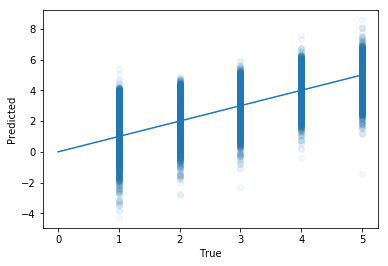

In [86]:
# countvectorizer training on portion of data

cv_matrix = transformation(CountVectorizer(stop_words = 'english'), text_array[indices], 'uint16')
Binarizer(copy=False).fit_transform(cv_matrix)
train_model(SGDRegressor(max_iter=50, random_state=100, penalty='l1'), cv_matrix,stars_array[indices])


Memory Usage (MB): 162.96991729736328
Time spent:29.104279041290283
R2 value: 0.5941729140316421


SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=50, n_iter=None, penalty='l1',
       power_t=0.25, random_state=100, shuffle=True, tol=None, verbose=0,
       warm_start=False)

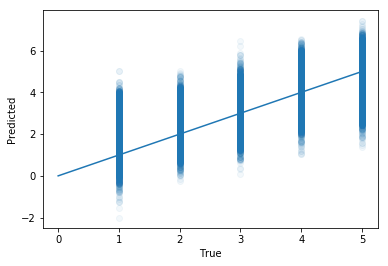

In [87]:
# TFIDF training

tfidf_matrix = transformation(TfidfVectorizer(stop_words='english'), 
                              text_array[indices], 'float16')

train_model(SGDRegressor(max_iter=50, random_state=100, penalty='l1'), 
            tfidf_matrix, stars_array[indices])


Memory Usage (MB): 162.96781158447266
Time spent:25.27001428604126
R2 value: 0.5984875088473496


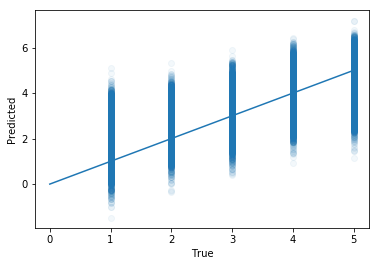

In [88]:
# HashVectorizer training

hash_matrix = transformation(HashingVectorizer(stop_words='english'),
                             text_array[indices], 'float16')
sgd_hashing = train_model(SGDRegressor(max_iter=50, random_state=100, penalty='l1'),
                          hash_matrix, stars_array[indices])


I've decided upon the HashVectorizer as the transformer

In [39]:
pipeline = Pipeline([('hashing', HashingVectorizer(stop_words='english')),
                     ('sgd', SGDRegressor(max_iter=50, random_state=100))                          
                     ])

parameters = {'hashing__ngram_range': [(1, 1), (1, 2)],
              'sgd__alpha': (3e-4, 1e-4, 3e-5),
              'sgd__penalty':('l2', 'l1', 'elasticnet')
              }


In [94]:
begin = time.time()

gs_reg = GridSearchCV(pipeline, parameters, scoring='r2')
gs_reg.fit(text_array[indices], stars_array[indices])

print('Best Score: {}'.format(gs_reg.best_score_))
print('Best Parameters: {}'.format(gs_reg.best_params_))

time.time()-begin


Best Score: 0.5018893306076191
Best Parameters: {'hashing__ngram_range': (1, 1), 'sgd__alpha': 3e-05, 'sgd__penalty': 'l2'}


709.1328301429749

In [95]:
y_pred = gs_reg.predict(text_array)
print('R2 for the rest of the dataset: {}'.format(r2_score(stars_array, y_pred))


0.5373482054972056

In [104]:
# Saving model to file
pickle.dump(gs_clf, open( "gridsearch.p", "wb" ))
